In [1]:
import sys,os
import xarray as xr
import numpy as np
import scipy as spy
import pickle 

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

In [3]:
import time as timestamp 
import importlib

In [4]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils as lim

import LIM_utils_kb as limkb
import LIM_stats_kb as statskb
import LIM_plot_kb as plotkb
import LIM_building as limbuild

sys.path.append("/home/disk/kalman2/mkb22/pyLMR/")
import LMR_utils

In [5]:
#--------------------------------------------------
# START USER PARAMETERS
#--------------------------------------------------
# number of EOFs to retain for the LIM state vector
ntrunc = 5 # EOF truncation for individual fields (reduced-state space)
nmodes = 15 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 20
nmodes_sic = 5
#modes_sic = 20

lat_cutoff = 50

mo='all'
#mo=0

# forecast lead time in months that defines the LIM training
tau = 1

# training data defined by the first ntrain times
# fraction of years used in training
# ensures that start year of both train and validation data is january
# nyearstrain = 30
# ntrain = int(nyearstrain*12)
# nvalid = int(38*12)
# nyearsvalid = 38-nyearstrain
# nvalidtimes = 1872

# variables to include in the LIM (note "vars" is a Python command)
#limvars = ['tas','zg']
#limvars = ['tas','rlut','zg']
#limvars = ['sic']
#limvars = ['tas','sic']
#limvars = ['tas','sic','zg','psl','pr','tos']
#limvars = ['tas','psl','tos','sit','sic']
# limvars = ['tas','tos','psl','sit','sic']
# limvars_nosic = ['tas','tos','psl','sit']
limvars = ['tas','sic']
#limvars = ['sic']
limvars_nosic = []
nvars = len(limvars)

# specify the model source 
#train_dsource = 'cmip6_mpi_hist'
train_dsource = 'cesm_lme'
#train_dsource = 'cmip6_mpi_hist_ssp585'
#train_dsource ='satellite'
#train_dsource = 'mpi_hist_kb'
#train_dsource = 'ccsm4_lm_kb'
#train_dsource = 'satellite'
#train_dsource = 'era5'
#valid_dsource = 'era5'
#valid_dsource = 'satellite'
#valid_dsource = 'mpi_lm_kb'
#valid_dsource = 'mpi_lm_kb'
#valid_dsource = 'cmip6_mpi_hist'
valid_dsource = 'cesm_lme'

sic_separate = True
Insamp = False

# date_of_interest = '20210910'

In [6]:
if 'hist_ssp585' in train_dsource: 
    folder_add = 'hist_ssp585_concatenated/'
elif 'hist' in train_dsource: 
    folder_add = 'historical/'
elif 'lm' in train_dsource: 
    folder_add = 'last_millennium/'
elif 'satellite' in train_dsource: 
    folder_add = 'satellite/'
elif 'era5' in train_dsource: 
    folder_add = 'reanalysis/'
elif 'lme' in train_dsource: 
    folder_add = 'last_millennium/'

In [21]:
# Start with truncated training data: 
#mod_folder = 'truncated_model_data/last_millennium/'
#mod_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/truncated_model_data/'+folder_add
mod_folder = '/home/disk/kalman2/mkb22/SI_LIMs/truncated_data/'+folder_add
#save_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/sensitivity_testing/neofs/'+folder_add
save_folder = '/home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/neofs/'+folder_add

#mod_filename = '_ntrunc'+str(ntrunc)+'_monthall_'+train_dsource+'_ntrain_1850_2050_20210916.pkl'
#mod_filename = '_ntrunc'+str(ntrunc)+'_monthall_'+train_dsource+'_grid05_ntrain_1979_2004_20210914.pkl'
#mod_filename = '_ntrunc'+str(ntrunc)+'_monthall_'+train_dsource+'_latcutoff_50_wtTrue_dtTrue_ntrain_1850_2004_20211014.pkl'
# mod_filename = ('_ntrunc'+str(ntrunc)+'_monthall_'+train_dsource+'_latcutoff_'+
#                 str(lat_cutoff)+'_wtTrue_dtTrue_ntrain_1850_2004_20211014.pkl')
mod_filename = ('_ntrunc'+str(ntrunc)+'_002_monthall_'+train_dsource+'_latcutoff_'+
                str(lat_cutoff)+'_wtTrue_dtTrue_ntrain_850_1650_20211014.pkl')

# mod_sic_filename = ('_ntrunc'+str(nmodes_sic)+'_monthall_'+train_dsource+'_latcutoff_'+
#                     str(lat_cutoff)+'_wtTrue_dtTrue_ntrain_1850_2004_20211014.pkl')
mod_sic_filename = ('_ntrunc'+str(nmodes_sic)+'_002_monthall_'+train_dsource+'_latcutoff_'+
                    str(lat_cutoff)+'_wtTrue_dtTrue_ntrain_850_1650_20211014.pkl')
#mod_sic_filename = ('_ntrunc'+str(nmodes_sic)+'_monthall_'+train_dsource+'_'+'ntrain_1850_2004_20210921.pkl')
#mod_sic_filename = '_ntrunc'+str(nmodes_sic)+'_monthall_'+train_dsource+'_latcutoff_50_ntrain_1850_2004_20210923.pkl'
#mod_sic_filename = '_ntrunc'+str(nmodes_sic)+'_monthall_'+train_dsource+'_latcutoff_50_wtTrue_dtTrue_ntrain_1850_2004_20211014.pkl'

#mod_sic_filename = '_ntrunc50_month0_mpi_hist_kb_20210727_ntrain1_standtest.pkl'
#mod_sic_filename = '_ntrunc50_mpi_lm_kb_20210507_ntrain0_3_standtest.pkl'
#train_dsource = 'cmip6_mpi_hist'

In [22]:
mod_sic_filename

'_ntrunc5_002_monthall_cesm_lme_latcutoff_50_wtTrue_dtTrue_ntrain_850_1650_20211014.pkl'

In [23]:
exp_setup = {}
exp_setup['mo'] = mo
if 'all' in str(mo): 
    exp_setup['ind_month_trunc'] = False
else: 
    exp_setup['ind_month_trunc'] = True
exp_setup['tau'] = tau
exp_setup['ntrunc'] = ntrunc 
exp_setup['nmodes_sic'] = nmodes_sic
exp_setup['limvars'] = limvars
exp_setup['train_dsource'] = train_dsource
exp_setup['valid_dsource'] = valid_dsource 
exp_setup['sic_separate'] = sic_separate
exp_setup['Insamp'] = Insamp
exp_setup['mod_folder'] = mod_folder
exp_setup['mod_filename'] = mod_filename
exp_setup['mod_sic_filename'] = mod_sic_filename
exp_setup['lat_cutoff'] = lat_cutoff
exp_setup['Weight']=True
exp_setup['step2_trunc']=False

# era5 settings (out of sample): 
# exp_setup['nyearsvalid'] = 16
# exp_setup['nyearstot'] = 42
# exp_setup['nyears_startvalid'] = 26*12

# era5 settings (in sample):  
# exp_setup['nyearsvalid'] = 26
# exp_setup['nyearstot'] = 42
# exp_setup['nyears_startvalid'] = 1*12

# Satellite settings (out of sample): 
# exp_setup['nyearsvalid'] = 12
# exp_setup['nyearstot'] = 38
# exp_setup['nyears_startvalid'] = 26*12

# Satellite settings (in sample): 
# exp_setup['nyearsvalid'] = 25
# exp_setup['nyearstot'] = 38
# exp_setup['nyears_startvalid'] = 1*12

# # Historical settings: 
# exp_setup['nyearsvalid'] = 10
# exp_setup['nyearstot'] = 164
# exp_setup['nyears_startvalid'] = 155*12

# Historical settings (in sample): 
# exp_setup['nyearsvalid'] = 10
# exp_setup['nyearstot'] = 164
# exp_setup['nyears_startvalid'] = 1*12

# LME settings (out of sample): 
exp_setup['nyearsvalid'] =200
exp_setup['nyearstrain'] = (1650-850)
exp_setup['nyearstot'] = 1155
exp_setup['nyears_startvalid'] = 801*12

# LME settings (in sample): 
# exp_setup['nyearsvalid'] = 11
# exp_setup['nyearstrain'] = (1350-851)
# exp_setup['nyearstot'] = 1155
# exp_setup['nyears_startvalid'] = 1*12

# LM settings
# exp_setup['nyearsvalid'] = 10
# exp_setup['nyearstot'] = 1000
# exp_setup['nyears_startvalid'] = 900*12
exp_setup['ntrain']=((exp_setup['nyearstot']*12)-(exp_setup['nyearsvalid'] *12))/(exp_setup['nyearstot']*12)

In [24]:
1650-850

800

In [25]:
month_names = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

In [26]:
import run_forecast_model_data as rf

In [27]:
importlib.reload(rf)
importlib.reload(limbuild)
importlib.reload(limkb)
importlib.reload(statskb)

<module 'LIM_stats_kb' from '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_stats_kb.py'>

In [28]:
master_save = False

In [29]:
#--------------------------------------------------
### Build L from truncated data: 
#--------------------------------------------------

save_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIMs_saved/'

LIMd = rf.build_L(exp_setup, save_folder, save=master_save)

Loading truncated tas from: /home/disk/kalman2/mkb22/SI_LIMs/truncated_data/last_millennium/tas_ntrunc5_002_monthall_cesm_lme_latcutoff_50_wtTrue_dtTrue_ntrain_850_1650_20211014.pkl
Month is all
Loading truncated sic from: /home/disk/kalman2/mkb22/SI_LIMs/truncated_data/last_millennium/sic_ntrunc5_002_monthall_cesm_lme_latcutoff_50_wtTrue_dtTrue_ntrain_850_1650_20211014.pkl
Month is all
working on tas
working on sic
Multiple variables detected...
0, tas
Training LIM with tau = 1
Number of positive eigenvalues = 0.0


In [16]:
full_names, areawt_name, month_names = limbuild.load_full_names()

#--------------------------------------------------
# BUILD L FROM PRE-TRUNCATED DATA: 
#--------------------------------------------------

[Ptrunc, _, E3, tot_var, 
 tot_var_eig, W_all, standard_factor, 
 nyears_train, var_dict] = limbuild.load_training_data_truncated(exp_setup['limvars'], exp_setup['mod_folder'], 
                                                                 exp_setup['mod_sic_filename'], 
                                                                 exp_setup['mod_filename'], 
                                                                 exp_setup['mo'],exp_setup['nyearstot'], 
                                                                 exp_setup['nyearstrain'],exp_setup['nyearsvalid'],
                                                                 ind_month_trunc=exp_setup['ind_month_trunc'])

var_dict = limbuild.get_var_indices(exp_setup['limvars'], var_dict)

ndof_all = limkb.count_ndof_all(exp_setup['limvars'], E3, sic_separate=exp_setup['sic_separate'])


if len(exp_setup['limvars'])<=1:
    print('Only one variable detected...')
    Ptrunc_all = []
    E3_all = []
    Ptrunc_sic = Ptrunc['sic']
    E_sic = E3['sic']

    P_train = Ptrunc_sic
else: 
    print('Multiple variables detected...')
    [Ptrunc_all, E3_all, 
    Ptrunc_sic,E_sic] = limkb.stack_variable_eofs(exp_setup['limvars'], ndof_all, 
                                                  exp_setup['ntrunc'], Ptrunc, E3,var_dict,
                                                  sic_separate=exp_setup['sic_separate'])

    P_train = np.concatenate((Ptrunc_all, Ptrunc_sic),axis=0)

Loading truncated tas from: /home/disk/kalman2/mkb22/SI_LIMs/truncated_data/last_millennium/tas_ntrunc5_002_monthall_cesm_lme_latcutoff_50_wtTrue_dtTrue_ntrain_850_1350_20211014.pkl
Month is all
Loading truncated sic from: /home/disk/kalman2/mkb22/SI_LIMs/truncated_data/last_millennium/sic_ntrunc5_002_monthall_cesm_lme_latcutoff_50_wtTrue_dtTrue_ntrain_850_1350_20211014.pkl
Month is all
working on tas
working on sic
Multiple variables detected...
0, tas


In [19]:
P_train.shape, Ptrunc['tas'].shape

((10, 6012), (5, 6012))

In [87]:
nmo = int(P_train.shape[1]/nyears_train)
# nmo = 2
#P_train_3d = np.reshape(P_train, (P_train.shape[0],nyears_train,nmo))

In [20]:
6012/12

501.0

In [95]:
nyears_train

9600

In [73]:
# #--------------------------------------------------
# ### Load pre-build L: 
# #--------------------------------------------------
# L_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIMs_saved/'
# L_filename = 'L_'+train_dsource+'_ntrain_1850_2005_tas30_tos30_sit30_sic50_'+date_of_interest+'.pkl'

# LIMd = pickle.load(open(L_folder+L_filename, 'rb'))

## Run Forecast: 

In [74]:
lags = [0,1,2,3,4,5,6]

if LIMd['npos_eigenvalues'] >0: 
    adj = True
else: 
    adj = False

exp_setup['lags'] = lags
exp_setup['adj'] = adj
exp_setup['remove_climo'] = True
exp_setup['detrend'] = True
exp_setup['nyr_train'] = None
exp_setup['Insamp'] = Insamp

f_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIMs_saved/'

In [75]:
forecast = rf.run_forecast(LIMd,exp_setup, f_folder, verbose=True, save=master_save, save_decomp=False)

Validation data: cesm_lme
tecut = 1001, tscut = 801.0
Loading from tas
Loading from a/LME/LIMs/tas_sfc_Amon_CESM_LMEallforc_002_085001-200512.nc
time dimension: 1651 - 1850
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
latitude cutoff detected: 50
-----------------------------------------------------
completed in 11.067499160766602 seconds
-----------------------------------------------------
Validation shape: (3168, 2400)
time dimension: 1651 - 1850
(2400,)
tecut = 1001, tscut = 801.0
Loading from sic
Loading from aIceData/LME/LIMs/sic_SImon_CESM_LME_nh_002_085001-200512.nc
time dimension: 1651 - 1850
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fil

In [ ]:
# L_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIMs_saved/'
# L_filename = 'Forecast_'+train_dsource+'_ntrain_1850_2005_tas30_tos30_sit30_sic50_'+date_of_interest+'.pkl'

# forecast = pickle.load(open(L_folder+L_filename, 'rb'))

In [46]:
forecast_validation = rf.validate_forecast_monthly(forecast, exp_setup['limvars'], 1, exp_setup, LIMd, f_folder, 
                                                   iplot=True, save=master_save)

Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 50
Loading from 2/Documents/SeaIceData/LME/LIMs/areacello_CESM_LME_nh_001.nc
latitude cutoff detected: 50
tecut = 1001, tscut = 801.0


KeyError: 'remove_climo'

In [34]:
# L_filename = ('Forecast_validation_'+train_dsource+
#               '_ntrain_1850_2005_tas30_tos30_sit30_sic50_'+date_of_interest+'.pkl')

# L_filename = ('Forecast_validation_cmip6_mpi_hist_ntrain_1850_2005_validation_mpi_lm_kb'+
#               '_0_100_tas30_tos30_sit30_sic50_20210826.pkl')

# forecast_validation_monthly = pickle.load(open(L_folder+L_filename, 'rb'))

Loading from mkb22/Documents/SeaIceData/LME/LIMs/areacello_CESM_LME_nh.nc
LME detected
latitude cutoff detected: 50
tecut = 12, tscut = 1.0
Loading from sic
Loading from eaIceData/LME/LIMs/siconc_SImon_CESM_LME_nh_085001-185012.nc
LME detected
time dimension: 852 - 862
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans

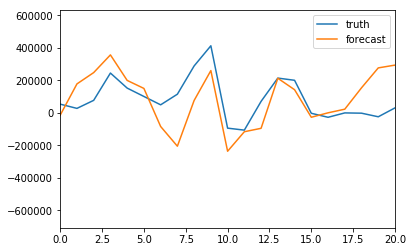

Lag 1
Trained using all months...
Truth_anom shape: (25600, 131)
Forecast_anom shape: (25600, 131)
changing cellarea units from m^2 to km^2


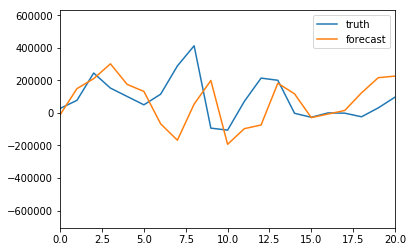

Lag 2
Trained using all months...
Truth_anom shape: (25600, 130)
Forecast_anom shape: (25600, 130)
changing cellarea units from m^2 to km^2


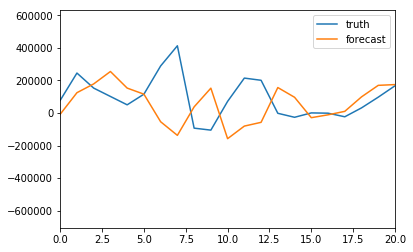

Lag 3
Trained using all months...
Truth_anom shape: (25600, 129)
Forecast_anom shape: (25600, 129)
changing cellarea units from m^2 to km^2


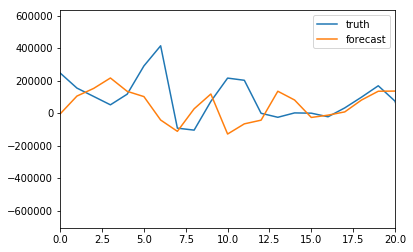

Lag 4
Trained using all months...
Truth_anom shape: (25600, 128)
Forecast_anom shape: (25600, 128)
changing cellarea units from m^2 to km^2


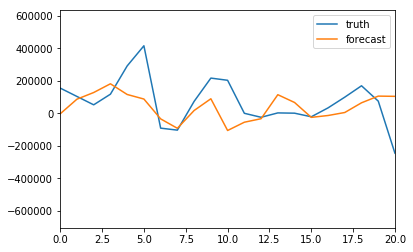

Lag 5
Trained using all months...
Truth_anom shape: (25600, 127)
Forecast_anom shape: (25600, 127)
changing cellarea units from m^2 to km^2


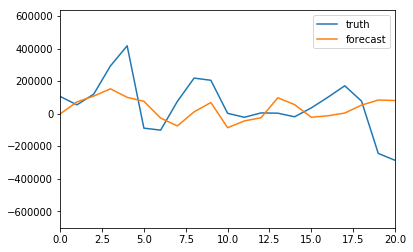

Lag 6
Trained using all months...
Truth_anom shape: (25600, 126)
Forecast_anom shape: (25600, 126)
changing cellarea units from m^2 to km^2


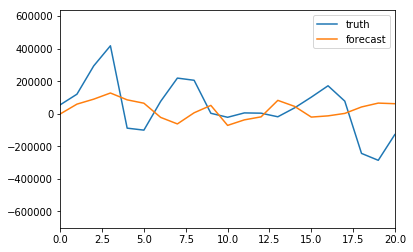

In [35]:
forecast_validation_lags = rf.validate_forecast_lagged(forecast, exp_setup['limvars'], exp_setup, LIMd, 
                                                       f_folder, iplot=True, save=master_save, 
                                                       detrend_truth=True)

In [ ]:
# L_filename = ('Forecast_validation_lagged_'+train_dsource+
#               '_ntrain_1850_2005_tas30_tos30_sit30_sic50_'+date_of_interest+'.pkl')

# L_filename = ('Forecast_validation_lagged_cmip6_mpi_hist_ntrain_1850_2005_validation_mpi_lm_kb'+
#               '_0_100_tas30_tos30_sit30_sic50_20210826.pkl')

# forecast_validation_lags = pickle.load(open(L_folder+L_filename, 'rb'))

### Testing error variance ratio: 

In [ ]:
fdic_train = limkb.build_training_dic(exp_setup['train_dsource'])
fdic_valid = limkb.build_training_dic(exp_setup['valid_dsource'])

areacell, areacell_dict = limbuild.load_areacell_dict(fdic_train, lat_cutoff=exp_setup['lat_cutoff'],
                                                      remove_climo=False, detrend=False, verbose=False )
full_names, areawt_name, month_names = limbuild.load_full_names()

v = {}
validation_stats_lags = {}

#    nyear_valid = exp_setup['nyearstot'] - exp_setup['nyearsvalid']


In [ ]:
var ='sic'

tecut = int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid'])
#        tecut = exp_setup['nyearstot'] - (int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid']))
if tecut <=0: 
    tecut = False
print('tecut = '+str(tecut) +', tscut = '+str(exp_setup['nyears_startvalid']/12))

X_var, _ = limkb.load_data(var, v, fdic_valid, remove_climo=True, detrend=True, verbose=True,
                           tscut=int(exp_setup['nyears_startvalid']/12), tecut=tecut, 
                           lat_cutoff=exp_setup['lat_cutoff'])

if var is 'sic':
    if np.nanmax(X_var)>1:
        print('Changing units of sic be a between 0 to 1')
        X_var = X_var/100

corr_tot = np.zeros((len(exp_setup['lags'])))
ce_tot = np.zeros((len(exp_setup['lags'])))
gm_var_ratio = np.zeros((len(exp_setup['lags'])))
valid_stats = {}


In [ ]:
#for i,lag in enumerate(exp_setup['lags']):
lag = 0
print('Lag '+str(lag))
#             [truth_anom, forecast_anom] = limbuild.gather_truth_forecast2(lag,var,exp_setup['mo'],X_var,
#                                                                           forecast['x_forecast_dcomp'],
#                                                                           exp_setup['nyearsvalid']*12,
#                                                                           LIMd['var_dict'],exp_setup['ntrain'],
#                                                                           exp_setup['nyears_startvalid'],
#                                                                           insamp=exp_setup['Insamp'])
[truth_anom, 
 forecast_anom] = limbuild.gather_truth_forecast_notime(lag,var,exp_setup['mo'],X_var,
                                                        forecast['x_forecast_dcomp'],
                                                        LIMd['var_dict'],insamp=exp_setup['Insamp'])


print('Truth_anom shape: '+str(truth_anom.shape))
print('Forecast_anom shape: '+str(forecast_anom.shape))

In [ ]:
X_var.shape

In [ ]:
units = areacell_dict[areawt_name[var]][areawt_name[var]]['units']
    
#Check cell area units: change all to km^2
if 'km' in units:
    acell = areacell[areawt_name[var]]
else: 
    print('changing cellarea units from '+
          str(areacell_dict[areawt_name[var]][areawt_name[var]]['units'])+' to km^2')
    acell = areacell[areawt_name[var]]*(1e-6)
    units = 'km^2'

In [ ]:
## New error var calculations: 09/23/21
forecast_nan_mask = np.where(np.isclose(np.nanvar(LIMd['E_sic'],axis=1),0,atol=1e-5),np.nan,1)

rmse = np.nanmean((truth_anom-forecast_anom)**2,axis=1)
gm_rmse = statskb.global_mean(rmse*truth_error_var_mask,acell)
gsum_rmse = np.nansum(gm_var_ratio)

if lag == 0:
    gsum_rmse_lag0 = gsum_rmse
    
gsum_rmse_ratio = gsum_rmse/gsum_rmse_lag0


In [ ]:
rmse.shape

In [ ]:
plt.pcolormesh(np.reshape(rmse*forecast_nan_mask, (360,304)))
#plt.plot(188,215,marker='.',color='r')
plt.colorbar()
# plt.xlim(180,210)
# plt.ylim(200,280)

In [ ]:
plt.pcolormesh(np.reshape(truth_error_var, (81, 720)))
#plt.plot(188,215,marker='.',color='r')
plt.colorbar()
# plt.xlim(180,210)
# plt.ylim(200,280)

In [ ]:
plt.pcolormesh(np.reshape(error_var, (81, 720)))
#plt.plot(188,250,marker='.',color='r')
plt.colorbar()
# plt.xlim(180,210)
# plt.ylim(200,280)

In [ ]:
plt.pcolormesh(np.reshape(gm_var_ratio_masked, (81, 720)),vmin=0, vmax=1.5)
plt.plot(450,30,marker='.',color='r')
plt.colorbar()
# plt.xlim(180,210)
# plt.ylim(200,280)

In [ ]:
np.nanmax(gm_var_ratio_masked)

In [ ]:
X_var_train_dt, _ = limkb.load_data(var, v, fdic_train, remove_climo=True, detrend=True, verbose=True,
                                 tscut=False, tecut=False, 
                                 lat_cutoff=exp_setup['lat_cutoff'])

In [ ]:
X_var_train, _ = limkb.load_data(var, v, fdic_train, remove_climo=False, detrend=False, verbose=True,
                                 tscut=False, tecut=False, 
                                 lat_cutoff=exp_setup['lat_cutoff'])

In [ ]:
504/12, forecast_anom.shape, 12*15, 42-16

In [ ]:
fig,axs = plt.subplots(1,1,figsize=(10,6))
plt.plot(np.arange(26,26+16,1),np.reshape(forecast_anom, (81,720,16,12))[30,450,:,0], label='forecast')

plt.plot(np.reshape(X_var_train_dt, (81,720,42,12))[30,450,:,0], label='training (detrended, \nclimo removed)')
plt.plot(np.reshape(X_var_train, (81,720,42,12))[30,450,:,0], label='training (raw)')
plt.legend(fontsize=14)

#plt.xlim(300,504)

plt.xlabel('timestep', fontsize=14)
plt.ylabel('Sea ice concentration (%)', fontsize=14)
plt.title('ERA5, January, Lat: 30/81, Lon: 450/720', fontsize=16)

In [ ]:
fig,axs = plt.subplots(1,1,figsize=(10,6))
plt.plot(np.arange(504-191,504,1),np.reshape(forecast_anom, (81,720,191))[30,450,:], label='forecast')

plt.plot(np.reshape(X_var_train_dt, (81,720,504))[30,450,:], label='training (detrended, \nclimo removed)')
plt.plot(np.reshape(X_var_train, (81,720,504))[30,450,:], label='training (raw)')
plt.legend(fontsize=14)

#plt.xlim(300,504)

plt.xlabel('timestep', fontsize=14)
plt.ylabel('Sea ice concentration (%)', fontsize=14)
plt.title('ERA5 Lat: 30/81, Lon: 450/720', fontsize=16)

In [ ]:
fig,axs = plt.subplots(1,1,figsize=(10,6))
plt.plot(np.reshape(forecast_anom, (360,304,143))[188,215,:], label='forecast')
plt.plot(np.reshape(truth_anom, (360,304,143))[188,215,:], label='truth')
plt.legend()
plt.xlabel('timestep', fontsize=14)
plt.ylabel('Sea ice concentration (%)', fontsize=14)
plt.title('Lat: 188/360, Lon: 215/304', fontsize=16)

## Run AR1 Forecast: 

In [ ]:
valid_vars=limvars
ar1f_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIMs_saved/'

ar1cast = rf.ar1_forecast_valid_by_month(LIMd['P_train'], forecast['P_train_valid'], LIMd,
                                         exp_setup, valid_vars, month_names, ar1f_folder, forecast,
                                         lag=None, iplot=True, save=master_save, save_decomp=False)

In [ ]:
# L_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIMs_saved/'
# L_filename = ('AR1_forecast_monthly_'+train_dsource+
#               '_ntrain_1850_1999_tas30_tos30_psl30_sit30_sic50_'+date_of_interest+'.pkl')

# ar1cast = pickle.load(open(L_folder+L_filename, 'rb'))

In [ ]:
ar1f_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIMs_saved/'

ar1cast_lags = rf.ar1_forecast_valid_by_lag(LIMd['P_train'], forecast['P_train_valid'], LIMd, exp_setup, 
                                            exp_setup['limvars'], month_names, ar1f_folder, forecast,
                                            iplot=True, save=master_save, save_decomp=False,
                                            detrend_truth=False)

In [ ]:
# L_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIMs_saved/'
# L_filename = ('AR1_forecast_lagged_'+train_dsource+
#               '_ntrain_1850_1999_tas30_tos30_psl30_sit30_sic50_'+date_of_interest+'.pkl')

# ar1cast_lags = pickle.load(open(L_folder+L_filename, 'rb'))

In [ ]:
str(forecast['var_dict_valid']['sic']['time'][0])[0:4]

In [ ]:
start_yr = str(forecast['var_dict_valid']['sic']['time'][0])[0:4]
end_yr = str(forecast['var_dict_valid']['sic']['time'][-1])[0:4]

exp_filename = ('Validation_'+exp_setup['train_dsource']+'_ntrain_'+exp_setup['mod_filename'][-22:-13]+
                '_validyrs_'+start_yr+'_'+end_yr+'_'+
                (str(exp_setup['ntrunc'])+"_").join(exp_setup['limvars'])+
                str(exp_setup['nmodes_sic'])+'_'+'.pkl')
exp_filename

## Validation by lag: 

In [ ]:
if 'cmip6' in train_dsource: 
    tcmip='CMIP6'
elif 'era' in train_dsource:
    tcmip=''
elif 'satellite' in train_dsource: 
    tcmip=''
else: 
    tcmip='CMIP5'

var = 'sic'
# start_tim = exp_setup['nyears_startvalid']
# end_tim = exp_setup['nyears_startvalid']+(exp_setup['nyearsvalid']*12)
valid_yrs_str = (str(forecast['var_dict_valid'][var]['time'][0])[:4]+'_'+
                 str(forecast['var_dict_valid'][var]['time'][-1])[:4])

if 'hist' in train_dsource:
    texp = 'Historical'
elif 'lm' in train_dsource: 
    texp = 'LM'
elif 'ssp585' in train_dsource: 
    texp = 'SSP585'
elif 'era5' in train_dsource: 
    texp = 'ERA5'
elif 'satellite' in train_dsource: 
    texp = 'Satellite'
    
if 'hist' in valid_dsource:
    vexp = 'Historical'
elif 'lm' in valid_dsource: 
    vexp = 'LM'
elif 'ssp585' in valid_dsource: 
    vexp = 'SSP585'
elif 'era5' in valid_dsource: 
    vexp = 'ERA5'
elif 'satellite' in valid_dsource: 
    vexp = 'Satellite'
    
if 'cesm2' in train_dsource:
    tmod = 'CESM2'
elif 'mpi' in train_dsource: 
    tmod = 'MPI'
elif 'gfdl' in train_dsource: 
    tmod = 'GFDL'
elif 'ccsm4' in train_dsource: 
    tmod = 'CCSM4'
elif 'era5' in train_dsource: 
    tmod = ''
elif 'satellite' in train_dsource: 
    tmod = ''
    
if 'cesm2' in valid_dsource:
    vmod = 'CESM2'
elif 'mpi' in valid_dsource: 
    vmod = 'MPI'
elif 'gfdl' in valid_dsource: 
    vmod = 'GFDL'
elif 'ccsm4' in valid_dsource: 
    vmod = 'CCSM4'
elif 'era5' in valid_dsource: 
    vmod = ''
elif 'satellite' in valid_dsource: 
    vmod = ''
    
if exp_setup['Weight'] is True: 
    wt_addin = ' '
else: 
    wt_addin = '(no area weighting)'
    
if exp_setup['detrend'] is True: 
    tr_addin = ' '
else: 
    tr_addin = ' (trended)'

In [ ]:
exp_setup['mod_filename']

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(20,10))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(exp_setup['limvars']):
    ax[i].plot(exp_setup['lags'][1:],forecast_validation_lags['validation_stats_lags'][var]['corr_tot'][1:]**2, 
               label='Correlation',linewidth=4)
    ax[i].plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['corr_tot'][:-1]**2, 
               label='AR(1) Correlation',linewidth=4, 
               linestyle='--', color='tab:blue',alpha=0.5)

    ax[i].plot(exp_setup['lags'][1:],forecast_validation_lags['validation_stats_lags'][var]['ce_tot'][1:],
               label='CE',linewidth=3.0)
    ax[i].plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['ce_tot'][:-1],
               label='AR(1) CE',linewidth=3.0, 
               linestyle='--', color='tab:orange', alpha=0.5)

    ax[i].set_xticks(np.arange(0,11,1))
    ax[i].set_xticklabels(np.arange(0,11,1),fontsize=12)
    ax[i].set_ylim(0,1)
    ax[i].set_xlim(1,6)
    ax[i].grid(axis='both')
    ax[i].set_title(var, fontsize=14)
#    ax[i].text(0.1,0.05, ("Mean R$^2$ = "+str(np.round(np.mean(validation_stats[var]['corr_tot']**2),2))),fontsize=14)
    
if Insamp==True:     
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: Historical'), fontsize=16)
else: 
    plt.suptitle(('LIM trained on all months'+wt_addin+tr_addin+'\n Training years: '+tcmip+' '+tmod+' '+texp+' '+
                  exp_setup['mod_sic_filename'][-22:-13]+', Validation years: '+vmod+' '+vexp+' '+
                  valid_yrs_str), fontsize=16)

# ax[i].text(0.1,0.05, ("Training years: "+str(850)+'-'+str(850+ntrain*1000)),fontsize=14)
# ax[i].text(0.1,0.05, ("Validation years: "+str(850+ntrain*1000)+'-1850'),fontsize=14)


ax[1].legend(loc='upper right', fontsize=14)
ax[2].set_xlabel('Lag (months)', fontsize=14)
ax[1].set_xlabel('Lag (months)', fontsize=14)
ax[3].set_xlabel('Lag (months)', fontsize=14)

plt.subplots_adjust(top=0.9)

In [ ]:
exp_setup['mod_filename']

In [ ]:
fig,axs = plt.subplots(1,1,figsize=(10,6))
#fig,axs= plt.subplots(2, 2)

for i,var in enumerate(['sic']):
    axs.plot(exp_setup['lags'][:],forecast_validation_lags['validation_stats_lags'][var]['corr_tot'][:]**2, 
               label='Correlation',linewidth=4)
    axs.plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['corr_tot'][:-1]**2, 
               label='AR(1) Correlation',linewidth=4, 
               linestyle='--', color='tab:blue',alpha=0.5)

    axs.plot(exp_setup['lags'][:],forecast_validation_lags['validation_stats_lags'][var]['ce_tot'][:],
               label='CE',linewidth=3.0)
    axs.plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['ce_tot'][:-1],
               label='AR(1) CE',linewidth=3.0, 
               linestyle='--', color='tab:orange', alpha=0.5)

    axs.set_xticks(np.arange(0,11,1))
    axs.set_xticklabels(np.arange(0,11,1),fontsize=12)
    axs.set_ylim(0,1)
    axs.set_xlim(0,8)
    axs.grid(axis='both')
#    ax.set_title(var, fontsize=14)
#    ax[i].text(0.1,0.05, ("Mean R$^2$ = "+str(np.round(np.mean(validation_stats[var]['corr_tot']**2),2))),fontsize=14)
    
if Insamp==True:     
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: Historical'), fontsize=16)
else: 
    plt.suptitle(('LIM trained on all months'+wt_addin+tr_addin+'\n Training years: '+tcmip+' '+tmod+' '+texp+' '+
                  exp_setup['mod_sic_filename'][-22:-13]+', \nValidation years: '+vmod+' '+vexp+' '+
                  valid_yrs_str), fontsize=16)

# ax[i].text(0.1,0.05, ("Training years: "+str(850)+'-'+str(850+ntrain*1000)),fontsize=14)
# ax[i].text(0.1,0.05, ("Validation years: "+str(850+ntrain*1000)+'-1850'),fontsize=14)


axs.legend(loc='upper right', fontsize=14)
axs.set_xlabel('Lag (months)', fontsize=14)
axs.set_xlabel('Lag (months)', fontsize=14)
axs.set_xlabel('Lag (months)', fontsize=14)

plt.subplots_adjust(top=0.85)

In [ ]:
forecast_validation_lags['validation_stats_lags'][var]['corr_tot'][:]**2, forecast_validation_lags['validation_stats_lags'][var]['ce_tot'][:]

In [ ]:
forecast_validation_lags['validation_stats_lags'][var]['gm_rmse'][:]

In [ ]:
fig,axs = plt.subplots(1,1,figsize=(10,6))
#fig,axs= plt.subplots(2, 2)

for i,var in enumerate(exp_setup['limvars']):
    axs.plot(exp_setup['lags'][:],forecast_validation_lags['validation_stats_lags'][var]['gm_rmse'][:], 
               label='LIM',linewidth=3.0, color='purple')
    axs.plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['gm_rmse'][:-1], 
               label='AR(1)',linewidth=3.0, linestyle='--', color='purple',alpha=0.5)

    axs.set_xticks(np.arange(0,11,1))
    axs.set_xticklabels(np.arange(0,11,1),fontsize=12)
    axs.set_ylim(0,0.018)
    axs.set_xlim(0,6)
    axs.grid(axis='both')
#    axs.set_title(var, fontsize=14)
    
    axs.axhline(1.0, color='k', linewidth=2, label='No skill')
    
if Insamp==True:     
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: Historical'), fontsize=16)
else:     
    plt.suptitle(('LIM trained on all months'+wt_addin+tr_addin+'\n Training years: '+tcmip+' '+tmod+' '+texp+' '+
                  exp_setup['mod_filename'][-22:-13]+', \nValidation years: '+vmod+' '+vexp+' '+
                  valid_yrs_str), fontsize=16)

# ax[i].text(0.1,0.05, ("Training years: "+str(850)+'-'+str(850+ntrain*1000)),fontsize=14)
# ax[i].text(0.1,0.05, ("Validation years: "+str(850+ntrain*1000)+'-1850'),fontsize=14)


axs.legend(loc='lower right', fontsize=14)
axs.set_xlabel('Lag (months)', fontsize=14)
axs.set_xlabel('Lag (months)', fontsize=14)
axs.set_xlabel('Lag (months)', fontsize=14)
axs.set_ylabel('Global mean RMSE', fontsize=14)

plt.subplots_adjust(top=0.85)

In [ ]:
fig,axs = plt.subplots(1,1,figsize=(10,6))
#fig,axs= plt.subplots(2, 2)

for i,var in enumerate(exp_setup['limvars']):
    axs.plot(exp_setup['lags'][:],forecast_validation_lags['validation_stats_lags'][var]['gsum_rmse'][:], 
               label='LIM',linewidth=3.0, color='purple')
    axs.plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['gsum_rmse'][:-1], 
               label='AR(1)',linewidth=3.0, linestyle='--', color='purple',alpha=0.5)

    axs.set_xticks(np.arange(0,11,1))
    axs.set_xticklabels(np.arange(0,11,1),fontsize=12)
#    axs.set_ylim(0,1.2)
    axs.set_xlim(0,6)
    axs.grid(axis='both')
#    axs.set_title(var, fontsize=14)
    
    axs.axhline(1.0, color='k', linewidth=2, label='No skill')
    
if Insamp==True:     
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: Historical'), fontsize=16)
else:     
    plt.suptitle(('LIM trained on all months'+wt_addin+tr_addin+'\n Training years: '+tcmip+' '+tmod+' '+texp+' '+
                  exp_setup['mod_filename'][-22:-13]+', \nValidation years: '+vmod+' '+vexp+' '+
                  valid_yrs_str), fontsize=16)

# ax[i].text(0.1,0.05, ("Training years: "+str(850)+'-'+str(850+ntrain*1000)),fontsize=14)
# ax[i].text(0.1,0.05, ("Validation years: "+str(850+ntrain*1000)+'-1850'),fontsize=14)


axs.legend(loc='lower right', fontsize=14)
axs.set_xlabel('Lag (months)', fontsize=14)
axs.set_xlabel('Lag (months)', fontsize=14)
axs.set_xlabel('Lag (months)', fontsize=14)
axs.set_ylabel('Sum of RMSE (50N)', fontsize=14)

plt.subplots_adjust(top=0.85)

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(20,10))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(exp_setup['limvars']):
    ax[i].plot(exp_setup['lags'][:],forecast_validation_lags['validation_stats_lags'][var]['gm_var_ratio'][:], 
               label='LIM',linewidth=3.0, color='purple')
    ax[i].plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['gm_var_ratio'][:-1], 
               label='AR(1)',linewidth=3.0, linestyle='--', color='purple',alpha=0.5)

    ax[i].set_xticks(np.arange(0,11,1))
    ax[i].set_xticklabels(np.arange(0,11,1),fontsize=12)
    ax[i].set_ylim(0,1.1)
    ax[i].set_xlim(0,6)
    ax[i].grid(axis='both')
    ax[i].set_title(var, fontsize=14)
    
    ax[i].axhline(1.0, color='k', linewidth=2, label='No skill')
    
if Insamp==True:     
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: Historical'), fontsize=16)
else:     
    plt.suptitle(('LIM trained on all months \n Training years: '+tcmip+' '+tmod+' '+texp+' '+
                  exp_setup['mod_filename'][-22:-13]+', Validation years: '+vmod+' '+vexp+' '+
                  valid_yrs_str), fontsize=16)

# ax[i].text(0.1,0.05, ("Training years: "+str(850)+'-'+str(850+ntrain*1000)),fontsize=14)
# ax[i].text(0.1,0.05, ("Validation years: "+str(850+ntrain*1000)+'-1850'),fontsize=14)


ax[1].legend(loc='lower right', fontsize=14)
ax[2].set_xlabel('Lag (months)', fontsize=14)
ax[1].set_xlabel('Lag (months)', fontsize=14)
ax[3].set_xlabel('Lag (months)', fontsize=14)

plt.subplots_adjust(top=0.9)

## Validation by month: 

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(20,9))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(exp_setup['limvars']):
    ax[i].plot(forecast_validation['validation_stats'][var]['corr_tot']**2, label='Correlation',linewidth=3.0)
    ax[i].plot(ar1cast['validation_stats_ar1'][var]['corr_tot']**2, label='AR(1) Correlation',linewidth=3.0, 
               linestyle='--', color='tab:blue',alpha=0.5)

    ax[i].plot(forecast_validation['validation_stats'][var]['ce_tot'],label='CE',linewidth=3.0)
    ax[i].plot(ar1cast['validation_stats_ar1'][var]['ce_tot'],label='AR(1) CE',linewidth=3.0, 
               linestyle='--', color='tab:orange', alpha=0.5)

    ax[i].set_ylim(0,1)
#     ax[i].set_xlim(0,10)
    ax[i].set_xticks(np.arange(0,11,1))
    ax[i].set_xticklabels(month_names,fontsize=12)#, rotation=45)
    ax[i].grid(axis='both')
    ax[i].set_title(var, fontsize=14)
    mn = np.round(np.mean(forecast_validation['validation_stats'][var]['corr_tot']**2),2)
    ax[i].text(0.1,0.05, ("Mean R$^2$ = "+str(mn)),fontsize=14)

if Insamp==True:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
# #                  ', Validation years: Historical'+str(850)+'-'+str(int(850+ntrain*1000))), fontsize=16)
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: Historical'), fontsize=16)

else:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+
#                   str(int(850+ntrain*1000))+', Validation years: '+
#                   str(int(850+ntrain*1000))+'-'+str(int(850+ntrain*1000+nvalidtimes/12))), fontsize=16)
    plt.suptitle(('LIM trained on all months \n Training years: '+tcmip+' '+tmod+' '+texp+' '+
                  exp_setup['mod_filename'][-23:-14]+', Validation years: '+vmod+' '+vexp+' '+
                  valid_yrs_str), fontsize=16)

# ax[i].text(0.1,0.05, ("Training years: "+str(850)+'-'+str(850+ntrain*1000)),fontsize=14)
# ax[i].text(0.1,0.05, ("Validation years: "+str(850+ntrain*1000)+'-1850'),fontsize=14)


ax[3].legend(loc='lower right', fontsize=14)
ax[2].set_xlabel('Forecasted month', fontsize=14)
ax[3].set_xlabel('Forecasted month', fontsize=14)
ax[3].set_xlabel('Forecasted month', fontsize=14)

plt.subplots_adjust(top=0.9)

In [ ]:
fig,axs = plt.subplots(1,1,figsize=(10,6))
#fig,axs= plt.subplots(2, 2)

for i,var in enumerate(['sic']):
    axs.plot(forecast_validation['validation_stats'][var]['corr_tot']**2, label='Correlation',linewidth=3.0)
    axs.plot(ar1cast['validation_stats_ar1'][var]['corr_tot']**2, label='AR(1) Correlation',linewidth=3.0, 
               linestyle='--', color='tab:blue',alpha=0.5)

    axs.plot(forecast_validation['validation_stats'][var]['ce_tot'],label='CE',linewidth=3.0)
    axs.plot(ar1cast['validation_stats_ar1'][var]['ce_tot'],label='AR(1) CE',linewidth=3.0, 
               linestyle='--', color='tab:orange', alpha=0.5)

    axs.set_ylim(0,1)
#     ax[i].set_xlim(0,10)
    axs.set_xticks(np.arange(0,11,1))
    axs.set_xticklabels(month_names,fontsize=12, rotation=45)
    axs.grid(axis='both')
#    ax[i].set_title(var, fontsize=14)
    mn = np.round(np.mean(forecast_validation['validation_stats'][var]['corr_tot']**2),2)
    axs.text(0.1,0.05, ("Mean R$^2$ = "+str(mn)),fontsize=14)

if Insamp==True:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
# #                  ', Validation years: Historical'+str(850)+'-'+str(int(850+ntrain*1000))), fontsize=16)
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: Historical'), fontsize=16)

else:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+
#                   str(int(850+ntrain*1000))+', Validation years: '+
#                   str(int(850+ntrain*1000))+'-'+str(int(850+ntrain*1000+nvalidtimes/12))), fontsize=16)
    plt.suptitle(('LIM trained on all months \n Training years: '+tcmip+' '+tmod+' '+texp+' '+
                  exp_setup['mod_sic_filename'][-22:-13]+', \n Validation years: '+vmod+' '+vexp+' '+
                  valid_yrs_str), fontsize=16)

# ax[i].text(0.1,0.05, ("Training years: "+str(850)+'-'+str(850+ntrain*1000)),fontsize=14)
# ax[i].text(0.1,0.05, ("Validation years: "+str(850+ntrain*1000)+'-1850'),fontsize=14)


axs.legend(loc='lower right', fontsize=14)
axs.set_xlabel('Forecasted month', fontsize=14)
axs.set_xlabel('Forecasted month', fontsize=14)
axs.set_xlabel('Forecasted month', fontsize=14)

plt.subplots_adjust(top=0.85)

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(20,9))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(limvars):
    ax[i].plot(forecast_validation['validation_stats'][var]['gm_var_ratio'],linewidth=3.0, color='purple')

    ax[i].plot(ar1cast['validation_stats_ar1'][var]['gm_var_ratio'],linewidth=3.0, color='purple', 
               linestyle='--', alpha=0.5)

#    ax[i].set_ylim(0,1)
    ax[i].set_xlim(0,10)
    ax[i].set_ylim(0,1.1)
    ax[i].set_xticks(np.arange(0,11,1))
    ax[i].set_xticklabels(month_names,fontsize=12)
    ax[i].grid(axis='both')
    ax[i].set_title(var, fontsize=16)
    ax[i].text(0.15,0.05, ("Mean ratio = "+str(np.round(np.mean(forecast_validation['validation_stats'][var]['gm_var_ratio']),2))),
               fontsize=14)
    ax[i].axhline(1.0,color='k',linestyle='--')

if Insamp==True:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
#                  ', Validation years: Historical'+str(850)+'-'+str(int(850+ntrain*1000))), fontsize=16)
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: Historical'), fontsize=16)
else:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+
#                   str(int(850+ntrain*1000))+', Validation years: '+
#                   str(int(850+ntrain*1000))+'-'+str(int(850+ntrain*1000+nvalidtimes/12))), fontsize=16)
    plt.suptitle(('LIM trained on all months \n Training years: '+tcmip+' '+tmod+' '+texp+' '+
                  exp_setup['mod_filename'][-23:-14]+', Validation years: '+vmod+' '+vexp+' '+
                  valid_yrs_str), fontsize=16)
    
ax[2].set_xlabel('Forecasted month', fontsize=14)
ax[1].set_xlabel('Forecasted month', fontsize=14)
ax[3].set_xlabel('Forecasted month', fontsize=14)
ax[0].set_ylabel('GM ratio: \nerror variance to true variance', fontsize=14)

plt.subplots_adjust(top=0.9)
#plt.tight_layout()

In [ ]:
LIMd['var_dict']['sic']['lat'].shape

In [ ]:
LIMd['var_dict']['sic']['var_ndof']/LIMd['var_dict']['sic']['lat'].shape[0]

In [ ]:
import xarray as xr

In [ ]:
dir_LME = '/home/disk/chaos/mkb22/Documents/SeaIceData/LME/'

dataset = xr.open_mfdataset(dir_LME+'b.e11.BLMTRC5CN.f19_g16.0*.aice_nh.185001-200512.nc', 
                            combine='nested', concat_dim='member')

In [ ]:
dataset = dataset.reset_coords('ULAT',drop=True)
dataset = dataset.reset_coords('ULON',drop=True)
dataset = dataset.drop('ANGLE')
dataset = dataset.drop('ANGLET')
dataset = dataset.drop('HTN')
dataset = dataset.drop('HTE')
dataset = dataset.drop('blkmask')
dataset = dataset.drop('dxt')
dataset = dataset.drop('dxu')
dataset = dataset.drop('dyt')
dataset = dataset.drop('dyu')
dataset = dataset.drop('latt_bounds')
dataset = dataset.drop('latu_bounds')
dataset = dataset.drop('lont_bounds')
dataset = dataset.drop('lonu_bounds')
dataset = dataset.drop('uarea')
dataset = dataset.drop('time_bounds')

In [ ]:
dataset = dataset.rename({'aice':'sic','TLON': 'lon','TLAT': 'lat', 'nj':'nlat', 'ni':'nlon'})


In [ ]:
dataset.to_netcdf(dir_LME+'siconc_SImon_CESM_LME_nh_185001-200512.nc')

In [ ]:

dataset = xr.open_mfdataset(dir_LME+'siconc_SImon_CESM_LME_nh_*.nc')

In [ ]:
dir_LME_rt = '/home/disk/kalman3/rtardif/LMR/data/model/cesm_lme/'
dir_LME = '/home/disk/chaos/mkb22/Documents/SeaIceData/LME/LIMs/'

In [ ]:
data = xr.open_dataset(dir_LME+'sic_SImon_CESM_LME_nh_085101-200512.nc')

In [ ]:
data

In [ ]:
data = data.rename({'aice':'sic','TLON': 'lon','TLAT': 'lat', 'nj':'nlat', 'ni':'nlon'})

In [ ]:
data

In [ ]:
data.to_netcdf(dir_LME+'sic_SImon_CESM_LME_nh_085101-200512_rename.nc')

In [ ]:
dataset.to_netcdf(dir_LME+'sic_SImon_CESM_LME_nh_085001-200512_2.nc')